In [1]:
import os
import sys
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from functools import reduce
import numpy.testing as npt
from operator import itemgetter, attrgetter
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
pd.options.display.float_format = '{:.2g}'.format

2024-11-12 10:09:28


In [2]:
from pynext.system_of_units import *

In [3]:
from pynext.Material import PhysicalMaterial
from pynext.PhysicalVolume import PhysicalVolume
from pynext.Shapes import Cylinder, CylinderShell, FlatPlate

In [4]:
from pynext.xetd import Xenon, CXe

In [5]:
from pynext.geometry import draw_cylinder, draw_2cylinder, draw_2cylynder_surface
from pynext.geometry import Cylinder as GCylinder
from pynext.geometry import vectors_spherical
from pynext.geometry import Ray, ray_intersection_with_cylinder
from pynext.geometry import generate_and_transport_gammas_lxe_shell
from pynext.geometry import generate_and_transport_gammas_lxe_endcaps
from pynext.histograms import h1d

In [6]:
from pynext.CylindricalVessel import  CVD
from pynext.CylindricalVessel import  CylindricalVessel
from pynext.Material import  cu12, cu03
from pynext.activity_functions import  activity_of_CV, print_activity_of_CV

# Toy LXe Detector

In [7]:
df = pd.read_hdf("XeCylinder.h5", "MC/hits")

In [8]:
df

,event_id,x,y,z,time,energy,label,particle_id,hit_id
0,0,32,4e+02,5.2e+02,1.5,0.0002,XE_CYLINDER,1,0
1,0,32,4e+02,5.2e+02,1.5,4.6e-05,XE_CYLINDER,30,0
2,0,32,4e+02,5.2e+02,1.5,2.1e-05,XE_CYLINDER,29,0
3,0,32,4e+02,5.2e+02,1.5,4.4e-05,XE_CYLINDER,28,0
4,0,32,4e+02,5.2e+02,1.5,4.7e-05,XE_CYLINDER,27,0
...,...,...,...,...,...,...,...,...,...
120635,1466,-1.5e+02,-3.6e+02,5.3e+02,1,0.018,XE_CYLINDER,8,17
120636,1466,-1.5e+02,-3.6e+02,5.3e+02,1,0.023,XE_CYLINDER,8,18
120637,1466,-1.5e+02,-3.6e+02,5.3e+02,1,0.016,XE_CYLINDER,8,19
120638,1466,-1.5e+02,-3.6e+02,5.3e+02,1,0.02,XE_CYLINDER,8,20


## Dimensions
- The toy LXe detector that we will consider is an idealisation of nEXO. It consists of a radiopure copper vessel hosting a TPC. The dimensions are taken from nEXO CDR.


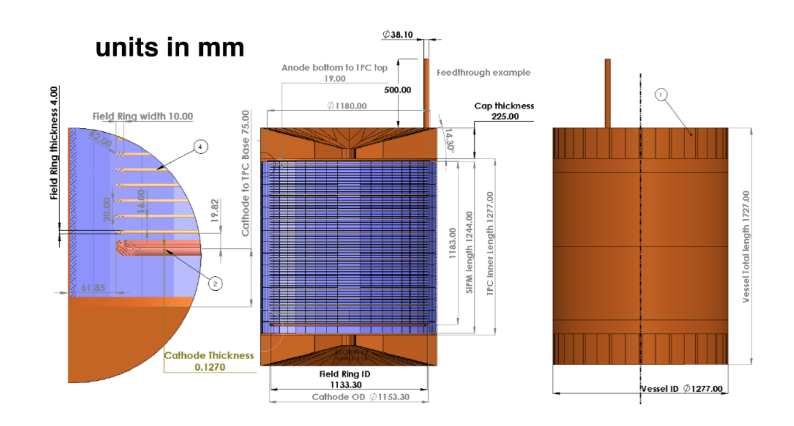

In [9]:
img = mpimg.imread('nexo.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Define the TPC

### Xenon

In [11]:
lxe = Xenon("lxe")
lxe


        material                                   = lxe
        density (rho)                              =       3 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =    0.12 cm^-1
        attenuation length (Latt)                  =     8.5 cm
    

### Xenon Volume


In [34]:
cathode_OD = 1153 * mm
TPC_D = 1180 * mm
TPC_L = 1183 * mm
catode_lxe_buffer = 75 * mm
anode_lxe_buffer = 19 * mm
TPC_fid_L = TPC_L - catode_lxe_buffer - anode_lxe_buffer
TPC_fid_D = cathode_OD
t_lxe_buffer = (TPC_D - TPC_fid_D)/2

lxetd = CXe(lxe, R=TPC_D/2, L=TPC_L, Rb=t_lxe_buffer/2, Cb=catode_lxe_buffer, Ab=anode_lxe_buffer)
lxetd


        
        material                                   = lxe
        density (rho)                              =       3 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =    0.12 cm^-1
        attenuation length (Latt)                  =     8.5 cm
    
        
        Fiducial Radius =   59.00 cm  xe Radius =   59.67 cm
        Fiducial Length =  118.30 cm  Xe Length =  127.70 cm
        
        Fiducial Volume =    1.29 m3 Xe Volume =    1.43 m3
        Fiducial mass = 3881.15 kg Xe mass = 4285.95 kg
        
        Radial buffer radius =    0.68 cm (E/P ~ 2)
        Cathode buffer thickness =    7.50 cm   (E/P~1)
        Anode buffer thickness =    1.90 cm
        
        Long buffer Volume =    0.03 m3
        Long buffer mass =   96.41 kg
        
        Cathode buffer Volume =    0.08 m3
        Cathode buffer mass =  251.72 kg
        
        Anode buffer Volume =    0.02 m3
        Anode bu

### Physics Volume
-Define a second LXe volume, the shielded volum,e in which one carries on physics (1 ton fiducial)


In [29]:

lxe_phys_radius = 405 * mm
lxe_phys_diameter = 2 * Rs
lxe_phys_length = 650 * mm

lxes = CXe(lxe, R=lxe_phys_radius, L=lxe_phys_length, Rb=0.01*mm, Cb=0.01*mm, Ab=0.01*mm)

In [30]:

lxes


        
        material                                   = lxe
        density (rho)                              =       3 g/cm3
        mass attenuation coefficient (mu_over_rho) =   0.039 cm2/g
        attenuation coefficient (mu)               =    0.12 cm^-1
        attenuation length (Latt)                  =     8.5 cm
    
        
        Fiducial Radius =   40.50 cm  xe Radius =   40.50 cm
        Fiducial Length =   65.00 cm  Xe Length =   65.00 cm
        
        Fiducial Volume =    0.33 m3 Xe Volume =    0.33 m3
        Fiducial mass = 1004.83 kg Xe mass = 1004.92 kg
        
        Radial buffer radius =    0.00 cm (E/P ~ 2)
        Cathode buffer thickness =    0.00 cm   (E/P~1)
        Anode buffer thickness =    0.00 cm
        
        Long buffer Volume =    0.00 m3
        Long buffer mass =    0.05 kg
        
        Cathode buffer Volume =    0.00 m3
        Cathode buffer mass =    0.02 kg
        
        Anode buffer Volume =    0.00 m3
        Anode bu

In [35]:
L_shield = (TPC_L - lxe_phys_length)/2
t_shield = (TPC_D - lxe_phys_diameter)/2
print(f"length of the LXe shield between vessel and physics volume = {L_shield/mm}")
print(f"thickness of the LXe shield between vessel and physics volume = {t_shield/mm}")

length of the LXe shield between vessel and physics volume = 266.5
thickness of the LXe shield between vessel and physics volume = 180.0


### Fraction of gammas that interact in Shielded volume
- We can make a first, rough estimation, computing the fraction of gammas travelling along the longitudinal axis that interact in the physics volume. We can also compute the fraction of gammas travelling along the radial axis that interact in the physics volume.
- Notice, however, that this number overestimates grossly the fraction of interactions in the physics volume, since gammas are emitted in all directions, and a big fraction of them never make it to the physics volume. 

In [37]:
print(f" Fraction of gammas along longitudinal axis that interact in Shielded volume ={lxetd.xe.material.transmittance_at_qbb(L_shield)}") 

 Fraction of gammas along longitudinal axis that interact in Shielded volume =0.04424335890652433


In [38]:
print(f" Fraction of gammas along radial axis that interact in Shielded volume ={lxetd.xe.material.transmittance_at_qbb(t_shield)}") 

 Fraction of gammas along radial axis that interact in Shielded volume =0.12172388949734589


### Copper vessel

In [39]:
## LXe Copper TPC

vessel_length   = 1727 * mm
vessel_diameter = 1277 * mm
vessel_radius = vessel_diameter/2
vessel_head_thickness = 225 * mm
vessel_body_thickness = (vessel_diameter - TPC_D)/2

print(f"LXe copper Vessel: Length = {vessel_length/mm} mm, diameter = {vessel_diameter/mm} mm")
print(f"LXe copper Vessel: thickness body = {vessel_body_thickness/mm} mm, thickness head = {vessel_head_thickness/mm} mm")

LXe copper Vessel: Length = 1727.0 mm, diameter = 1277.0 mm
LXe copper Vessel: thickness body = 48.5 mm, thickness head = 225.0 mm


In [40]:
culxe = CVD(name    ='LXeCuVessel',
            R       = vessel_radius,
            th_body = vessel_body_thickness,
            L       = vessel_length,
            th_head = vessel_head_thickness)
culxe

CVD(name='LXeCuVessel', R=638.5, th_body=48.5, L=1727.0, th_head=225.0)

### We create a cylindrical vessel filled up with cu12, a type of radiopure copper.

In [172]:
pvlxe = CylindricalVessel(name='LXeVessel', material=cu03, cvd=culxe)
pvlxe


        Cylindrical Vessel:

        ----------------
        name      = LXeCuVessel
        material  = CuBest

        specific activity of material:
        Bi-214    = 3.00e-03 mBq/kg
        Tl-208    = 1.40e-03 mBq/kg

        body:
        R              =  638.50 mm
        body thickness =   48.50 mm
        head thickness =  225.00 mm
        length         = 1727.00 mm
        surface        = 6.93e+06 mm2
        volume         = 3.49e+08 mm3
        mass           = 3125.16 kg
        activity Bi-214 =    9.38 mBq, self-shielded =   1.55 mBq
        activity Tl-208 =    4.38 mBq, self-shielded =   0.72 mBq
        transmittance   = 1.84e-01

        heads:
        thickness =  225.00 mm
        surface   = 2.56e+06 mm2
        volume    = 5.76e+08 mm3
        mass      = 5164.07 kg
        activity Bi-214 =    7.75 mBq, self-shielded =   0.31 mBq
        activity Tl-208 =    3.61 mBq, self-shielded =   0.15 mBq
        transmittance   = 3.85e-04

        

### Activity of Cu vessel
- The activity depends on the assumptions for radiopurity, in this case corresponds to best limits on copper.
- Most of the activity is self-shielded, so that the remaining activity is a small fraction, larger for Bi-214 than for Tl-208 and larger in the radial direction than in the axial direction where self-shield is larger.
- It follows that the dominant effect for radioactivity will be Bi-214 gammas shot from the body of the vessel.
- Notice also that Bi-214 gammas are ~10 keV of Xe-137 Qbb, and thus with the resolution of LXe cannot be separated at all using resolution

In [173]:
cs_activity = activity_of_CV('activity of LXe PV (self-shielded)', pvlxe)
print_activity_of_CV(cs_activity, unit='mBq')


    activity 		 activity of LXe PV (self-shielded)
    body  (Bi-214) 	    1.55 mBq
    head  (Bi-214) 	    0.31 mBq
    total (Bi-214) 	    1.86 mBq
    body  (Tl-208) 	    0.72 mBq
    head  (Tl-208) 	    0.15 mBq
    total (Tl-208) 	    0.87 mBq
    


## Generation of gammas and transport
- Our next goal is to estimate the fraction of gammas of 2.5 MeV (e.g, Bi-214) emitted from the copper vessel that will make it into the physics volume. This gammas represent an irreducible background, since they cannot be separated from signal (they produce a photolectric interaction with the same energy than the Qbb decay)
- This is simply an acceptance calculation. We will do it defining a volume (cshell) that represents the copper vessel and a second volume (cphys) that represents the LXe volume in which we want to do physics. We then shoot uniformly gammas from chsell in an angle of 2pi (since the activity that we have computed is already shielded, and includes those gammas that are shot backwards) and compute how many of them reach cphys.
- We use GGylinder, which represents a Geometrical-Cylinder (e.g, in space). All dimensions assumed to be in mm
- Notice that the dimensions of the shell cylinder correspond to the dimensions of the TPC, not to the cupper vessel, since we have already computed the attenuation of the copper.

### Test
- We start defining test volumes to certify the procedure 

#### Test 1 we define to cylinders almost identical
- WF is a vector o weights for each gamma that is emitted. A gamma with weight zero does not reach the physics volume. A gamma with weight one reaches non-attenuated the physics colume.
- DST is a vector of distances travelled by gammas.

In [94]:
r1 = 100  # Radius of cylinder c1
zmin1 = 0  # Minimum z of cylinder c1
zmax1 = 100   # Maximum z of cylinder c1
r2 = 98   # Radius of inner cylinder c2
zmin2 = 1   # Minimum z of cylinder c2
zmax2 = 99    # Maximum z of cylinder c2


In [95]:
c1 =GCylinder(r1, zmin1, zmax1)
c1

Cylinder(r=100, zmin=0, zmax=100)

In [96]:
c2 =GCylinder(r2, zmin2, zmax2)
c2

Cylinder(r=98, zmin=1, zmax=99)

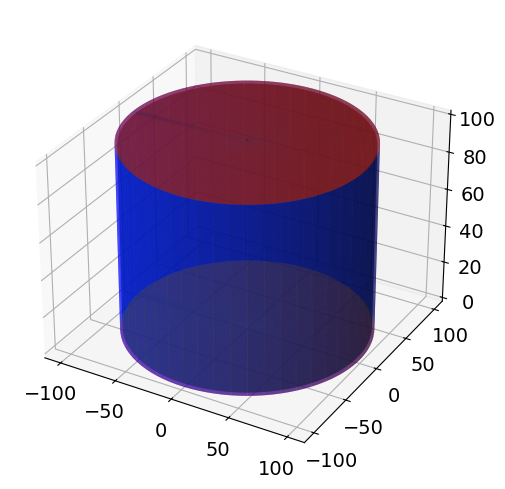

In [97]:
draw_2cylinder(c1, c2, alpha=0.5, figsize=(6,6))

- NB, cylinders are amost indistinguishable. 

c1 =Cylinder(r=100, zmin=0, zmax=100)
c2 =Cylinder(r=98, zmin=1, zmax=99)


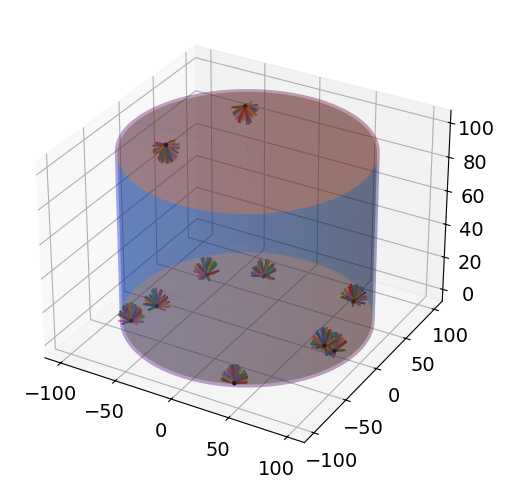

In [99]:
WF, DST = generate_and_transport_gammas_lxe_endcaps(c1, c2, 
                                       nphotons=10, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=True, scale=10)

In [100]:
np.mean(WF)

0.932883558392968

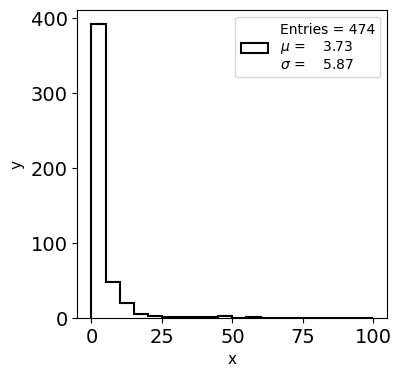

In [101]:
n, b, mu, std = h1d(DST, 20, (0, 100), figsize=(4,4)) 

c1 =Cylinder(r=100, zmin=0, zmax=100)
c2 =Cylinder(r=98, zmin=1, zmax=99)


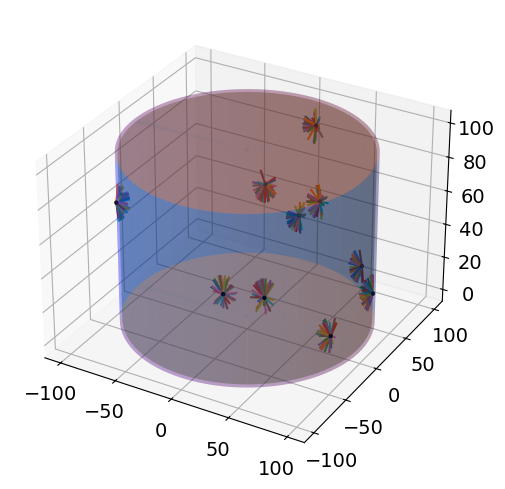

In [102]:
WF, DST = generate_and_transport_gammas_lxe_shell(c1, c2, 
                                       nphotons=10, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=True, scale=10)

In [103]:
np.mean(WF)

0.8228403295141693

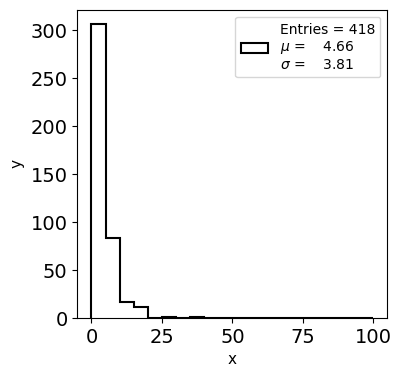

In [104]:
n, b, mu, std = h1d(DST, 20, (0, 100), figsize=(4,4)) 

c1 =Cylinder(r=100, zmin=0, zmax=100)
c2 =Cylinder(r=98, zmin=1, zmax=99)


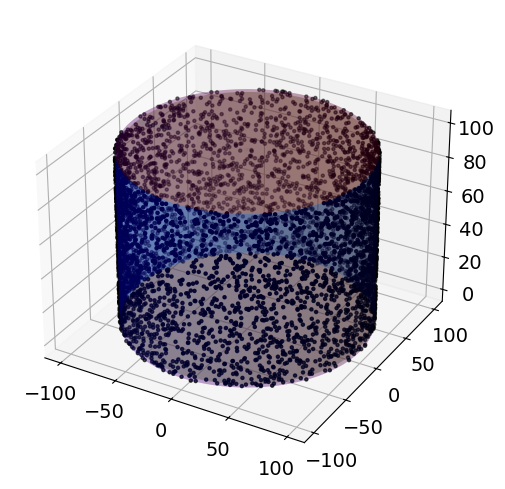

In [105]:
WF, DST = generate_and_transport_gammas_lxe_shell(c1, c2, 
                                       nphotons=5000, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=False)

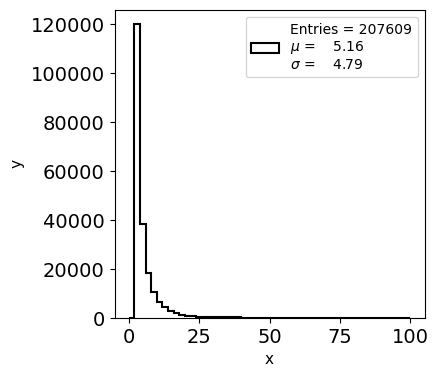

In [106]:
n, b, mu, std = h1d(DST, 50, (0, 100), figsize=(4,4)) 

In [107]:
print(f"average distance travelled by interacting gammas = {mu} mm")

average distance travelled by interacting gammas = 5.161169399204555 mm


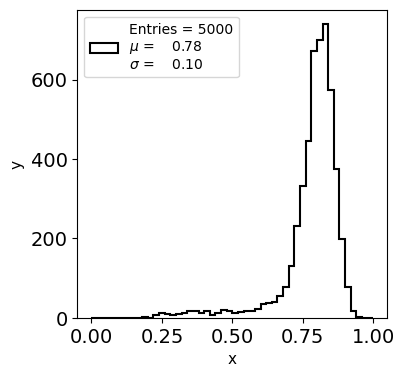

In [108]:
n, b, mu, std = h1d(WF, 50, (0, 1), figsize=(4,4)) 

In [109]:
print(f"average weight of gammas = {mu}")

average weight of gammas = 0.7835977335158075


c1 =Cylinder(r=100, zmin=0, zmax=100)
c2 =Cylinder(r=98, zmin=1, zmax=99)


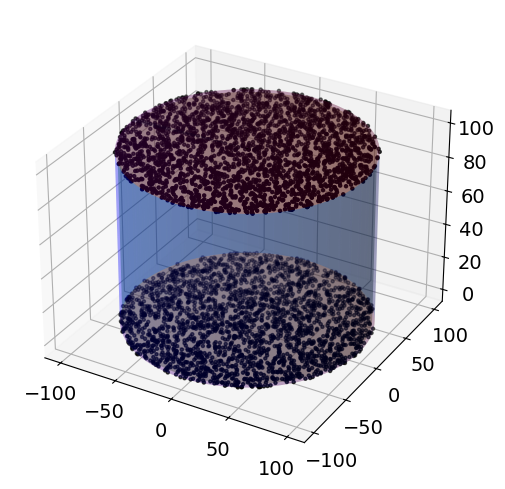

In [110]:
WF, DST = generate_and_transport_gammas_lxe_endcaps(c1, c2, 
                                       nphotons=5000, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=False)

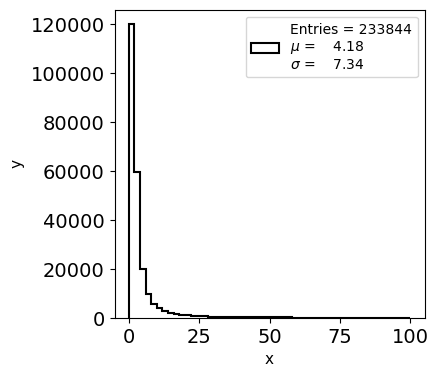

In [111]:
n, b, mu, std = h1d(DST, 50, (0, 100), figsize=(4,4)) 

In [112]:
print(f"average distance travelled by interacting gammas = {mu} mm")

average distance travelled by interacting gammas = 4.180019925227536 mm


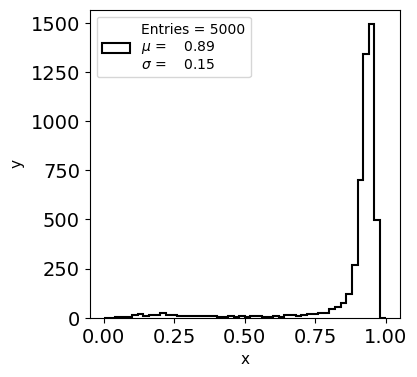

In [113]:
n, b, mu, std = h1d(WF, 50, (0, 1), figsize=(4,4)) 

In [114]:
print(f"average weight of gammas = {mu}")

average weight of gammas = 0.8909277831178981


- As expected, given that the two cylinders are very close, the attenuation is small and the Weight vector is close to one.
  

#### Test 2 we define one cylinder half of the other
- The LXe buffer is now 50 mm.

In [115]:
r1 = 100  # Radius of cylinder c1
zmin1 = 0  # Minimum z of cylinder c1
zmax1 = 100   # Maximum z of cylinder c1
r2 = 50   # Radius of inner cylinder c2
zmin2 = 25   # Minimum z of cylinder c2
zmax2 = 75    # Maximum z of cylinder c2


In [116]:
c1 =GCylinder(r1, zmin1, zmax1)
c2 =GCylinder(r2, zmin2, zmax2)
print(c1)
print(c2)

Cylinder(r=100, zmin=0, zmax=100)
Cylinder(r=50, zmin=25, zmax=75)


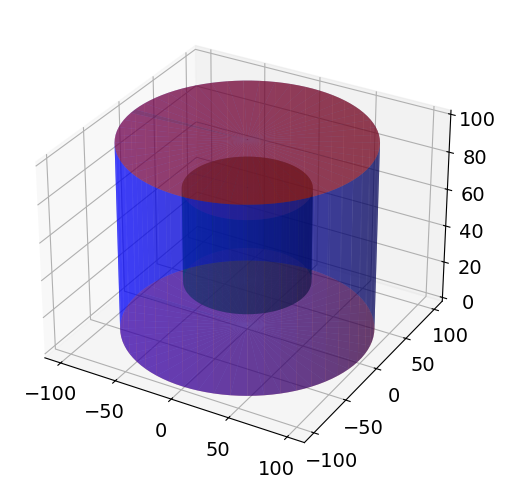

In [117]:
draw_2cylinder(c1, c2, alpha=0.5, figsize=(6,6))

#### Gammas emitted by the body

c1 =Cylinder(r=100, zmin=0, zmax=100)
c2 =Cylinder(r=50, zmin=25, zmax=75)


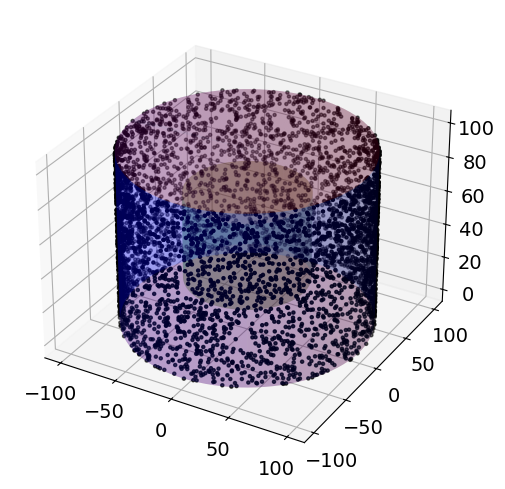

In [118]:
WF, DST = generate_and_transport_gammas_lxe_shell(c1, c2, 
                                       nphotons=5000, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=False)

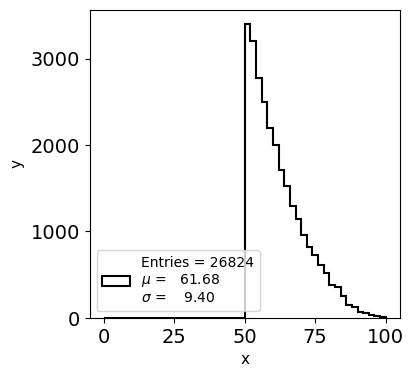

In [119]:
n, b, mu, std = h1d(DST, 50, (0, 100), figsize=(4,4)) 

In [120]:
print(f"average distance travelled by interacting gammas = {mu} mm")

average distance travelled by interacting gammas = 61.68380773413918 mm


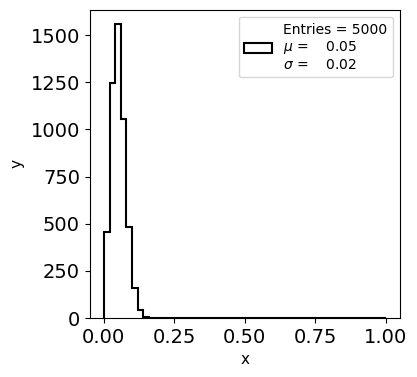

In [121]:
n, b, mu, std = h1d(WF, 50, (0, 1), figsize=(4,4)) 

In [122]:
print(f"average weight of interacting gammas = {mu}")

average weight of interacting gammas = 0.05215080004104649


#### gammas emitted by endcaps

c1 =Cylinder(r=100, zmin=0, zmax=100)
c2 =Cylinder(r=50, zmin=25, zmax=75)


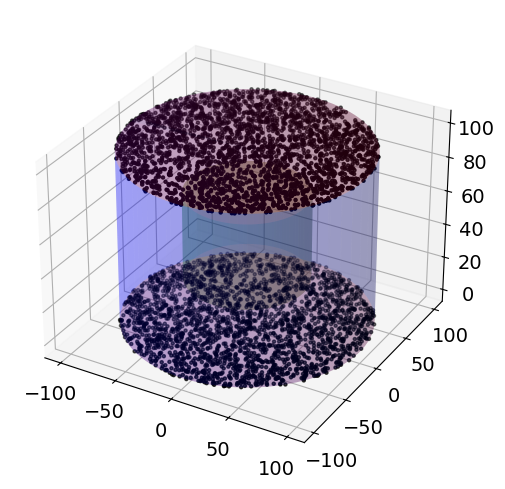

In [123]:
WF, DST = generate_and_transport_gammas_lxe_endcaps(c1, c2, 
                                       nphotons=5000, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=False)

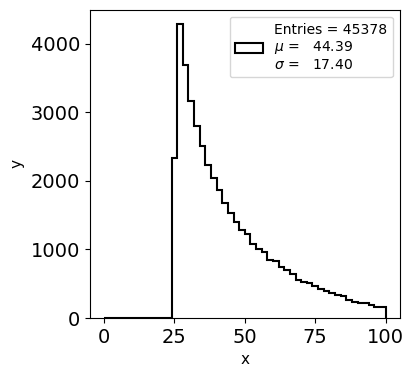

In [124]:
n, b, mu, std = h1d(DST, 50, (0, 100), figsize=(4,4)) 

In [125]:
print(f"average distance travelled by interacting gammas = {mu} mm")

average distance travelled by interacting gammas = 44.38581839116095 mm


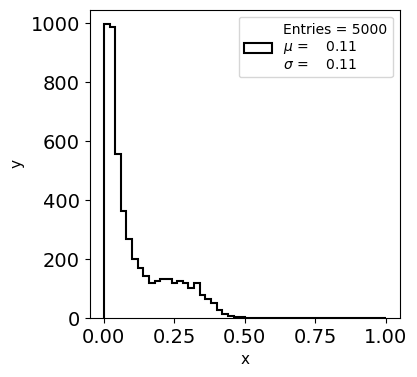

In [126]:
n, b, mu, std = h1d(WF, 50, (0, 1), figsize=(4,4)) 

In [127]:
print(f"average weight of interacting gammas = {mu}")

average weight of interacting gammas = 0.1079456769107842


## Generation and transport in Xe LXe toy detector

In [128]:
cshell =GCylinder(TPC_D/2, zmin = 0, zmax = TPC_L)
cshell

Cylinder(r=590.0, zmin=0, zmax=1183.0)

In [129]:
zmin = (TPC_L - lxe_phys_length) / 2
zmax = zmin + lxe_phys_length
cphys =GCylinder(lxe_phys_radius, zmin, zmax)
cphys

Cylinder(r=405.0, zmin=266.5, zmax=916.5)

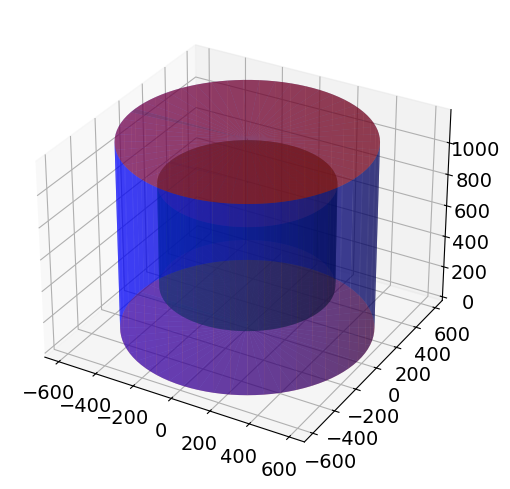

In [130]:
draw_2cylinder(cshell, cphys, alpha=0.5, figsize=(6,6))

#### Transport in the Barrel

c1 =Cylinder(r=590.0, zmin=0, zmax=1183.0)
c2 =Cylinder(r=405.0, zmin=266.5, zmax=916.5)


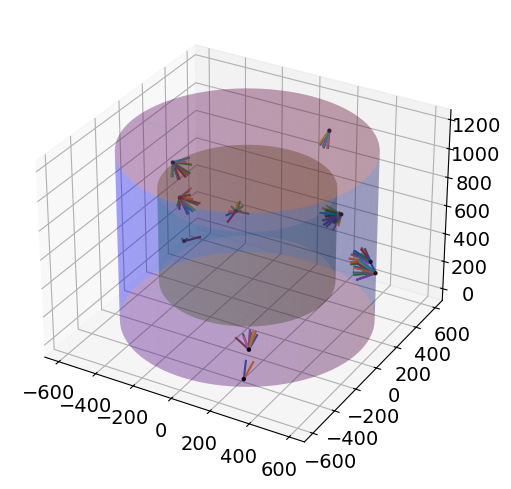

In [132]:
WF, DST = generate_and_transport_gammas_lxe_shell(cshell, cphys, 
                                       nphotons=10, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=True, scale=100)

c1 =Cylinder(r=590.0, zmin=0, zmax=1183.0)
c2 =Cylinder(r=405.0, zmin=266.5, zmax=916.5)


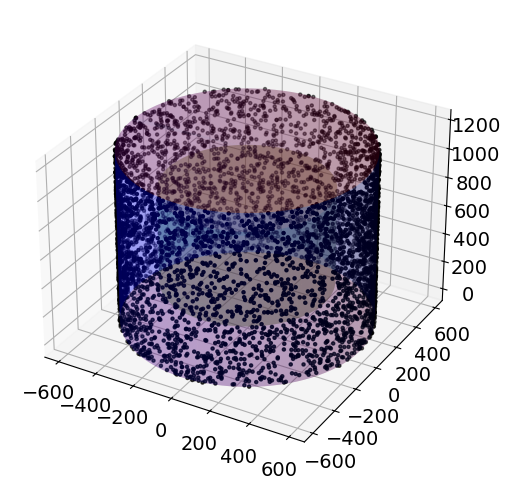

In [150]:
WF, DST = generate_and_transport_gammas_lxe_shell(cshell, cphys, 
                                       nphotons=5000, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=False, scale=100)

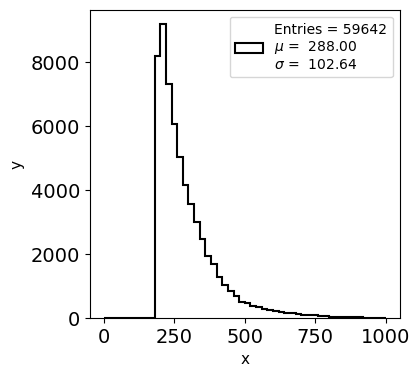

In [151]:
n, b, mu, std = h1d(DST, 50, (0, 1000), figsize=(4,4)) 

In [152]:
print(f"average distance travelled by interacting gammas = {mu} mm")

average distance travelled by interacting gammas = 287.9996996502849 mm


In [154]:
print(f"average attenuation, exponential law = {np.exp(-mu/85)}")

average attenuation, exponential law = 0.03376833463951089


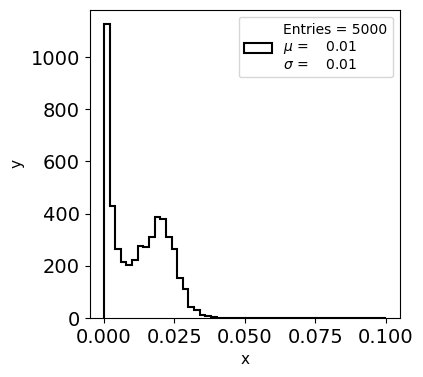

In [155]:
n, b, mu, std = h1d(WF, 50, (0, 0.1), figsize=(4,4)) 

In [156]:
print(f"mean weight in barrel = {std:7.3g}")

mean weight in barrel = 0.00942


- The weight of gammas in the barrel is reduced from the naive value (3%) to 1% when transport is included.

#### Transport end-caps

c1 =Cylinder(r=590.0, zmin=0, zmax=1183.0)
c2 =Cylinder(r=405.0, zmin=266.5, zmax=916.5)


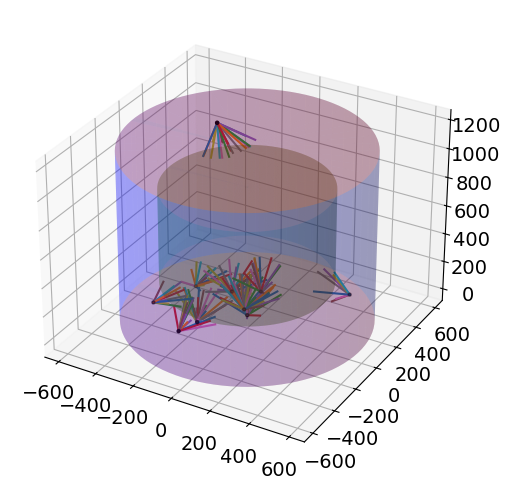

In [140]:
WF, DST = generate_and_transport_gammas_lxe_endcaps(cshell, cphys, 
                                       nphotons=10, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=True, scale=200)

c1 =Cylinder(r=590.0, zmin=0, zmax=1183.0)
c2 =Cylinder(r=405.0, zmin=266.5, zmax=916.5)


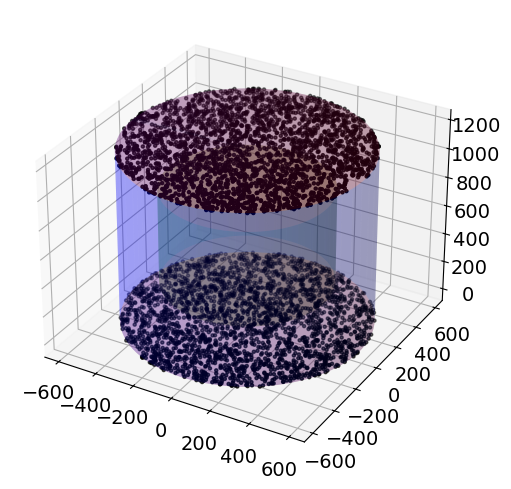

In [141]:
WF, DST = generate_and_transport_gammas_lxe_endcaps(cshell, cphys, 
                                       nphotons=5000, ndx= 100, 
                                       solidAngle="half",
                                       verbose=1, drawRays=False, scale=100)

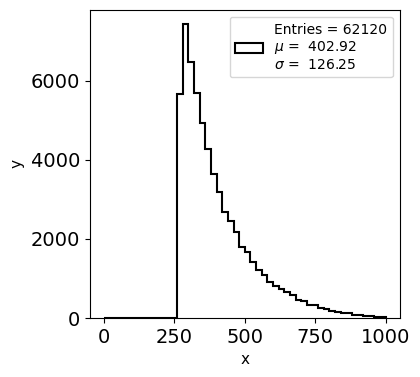

In [143]:
n, b, mu, std = h1d(DST, 50, (0, 1000), figsize=(4,4)) 

In [144]:
print(f"average distance travelled by interacting gammas = {mu} mm")

average distance travelled by interacting gammas = 402.91590346908947 mm


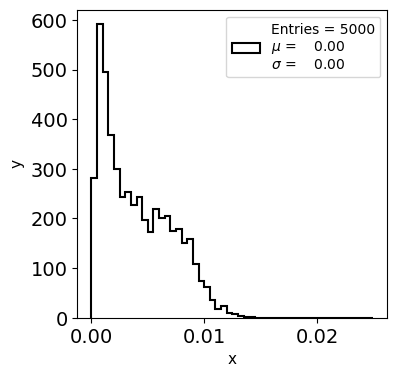

In [147]:
n, b, mu, std = h1d(WF, 50, (0, 0.025), figsize=(4,4)) 

In [149]:
print(f"mean weight in end-caps = {std:7.2g}")

mean weight in end-caps =   0.003


- The mean weight in the case of endcaps is even smaller (0.3%) given the longer attenuation. 

## Background of Bi-214 due to copper vessel. 

$$ R_{\gamma(2448 keV)}^{{}^{214}Bi} = A^{{}^{214}Bi} {\rm [Bq]} \times BR^{{}^{214}Bi}_{\gamma(2448 keV)} = 1.55 \cdot 10^{-3} {\rm [cts/sec]} \times 1.5 \cdot 10^{-2}$$

$$ N_{\gamma(2448 keV)}^{{}^{214}Bi} {\rm ~1 year} = R_{\gamma(2448 keV)}^{{}^{214}Bi} \times 3.1 \cdot 10^7 $$

$$ I_{\gamma(2448 keV)}^{{}^{214}Bi} {\rm ~ year/ROI/ton} = N_{\gamma(2448 keV)}^{{}^{214}Bi} \times f_{\gamma(2448 keV)}^{ROI} $$

### Background due to body


In [180]:
rg = 1.55e-3 * 1.5E-2
ng = rg * year/second
ig = ng * 0.0094
print(f"rate of gammas of 2448 keV emitted by copper (self-shielded) = {rg}")
print(f"number of gammas of 2448 keV emitted by copper (one year) = {ng}")
print(f"number of gammas of 2448 keV interacting in fiducial volume = {ig}")

rate of gammas of 2448 keV emitted by copper (self-shielded) = 2.325e-05
number of gammas of 2448 keV emitted by copper (one year) = 733.212
number of gammas of 2448 keV interacting in fiducial volume = 6.8921928


### Background due to end-caps

In [181]:
rg = 0.31e-3 * 1.5E-2
ng = rg * year/second
ig = ng * 0.003
print(f"rate of gammas of 2448 keV emitted by copper (self-shielded) = {rg}")
print(f"number of gammas of 2448 keV emitted by copper (one year) = {ng}")
print(f"number of gammas of 2448 keV interacting in fiducial volume = {ig}")

rate of gammas of 2448 keV emitted by copper (self-shielded) = 4.6499999999999995e-06
number of gammas of 2448 keV emitted by copper (one year) = 146.6424
number of gammas of 2448 keV interacting in fiducial volume = 0.4399272
